<h1 style="color:rgb(8, 72, 135)">The 2025 EY Open Science AI and Data Challenge: Cooling Urban Heat Islands (External Participants)</h1>
<h2>Team Vietnamese</h2>

- Ranked <span style="color:rgb(8, 72, 135)">67th global</span> among 10,000+ participants (each team max 3 members).

- Ranked <span style="color:rgb(8, 72, 135)">7th in Australia</span>.

Last update: 2025-Jun-4

The notebook contains our technical Python work for the competition, including the data manipulation, feature selection, model training & feature evaluation process.

<h3>Workflow brief:</h3>

- I. Load libaries & dependencies

- II. Process data 

- III. Machine Learning

<h3>Our comments:</h3>

<h5 style="color:rgb(0, 210, 255)">

The success of the project is heavily focused on data manipulation and feature engineering. There's not much to do in the modelling step. Correct data processing & cleaning and feature selection is the key to improve model's performance in this competition.

</h5>

## I. Import libraries & dependencies

Let's import important libraries that we'll use in the notebook.

In [ ]:
# run this to install these packages
# pip install -r requirements.txt 

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import os # for file management
import pandas as pd
import numpy as np

# Machine Learning
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import shap

As the notebook is stored in `notebooks` directory, we need to change the working directory to the root to make it easier to import the modules or datasets

In [2]:
# Change the working directory to the projec's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(project_root)
os.getcwd()

%run src/config.py

Import `data_processing` module, which contain Satallite data processing classes & functions. Function details can be found in the module file at `src/data_processing.py`

In [20]:
from src.data_processing import SatelliteDataExtractor, SatelliteDataManipulator
from src import kml_processor, utils
from src.modelling import Modelling

## II. Data processing



In the model, we'll use 3 sources of data:
1. <span style="color:rgb(8, 72, 135)">Temperature data (.csv)</span>: Include the longitude and latitude of 11.2k places, with the UHI index of each place. The UHI index is the model target variable. Note that longitude and latitude cannot be used as model features (competition rules) but can be used to help manipulating other data.

2. <span style="color:rgb(8, 72, 135">European Space Agency's Sentinel-2 & NASA Landsat satellite data (.tiff)</span>: Earth ground optical observed data from ESA & NASA satellite, the data is downloaded from Microsoft's Planetary Computer using API then preprocessed for modelling. Spectral band values collected will be used as features and used to compute band combination such as the Normalized Difference Vegetation Index(NDVI),... Note that focal buffer, which is of each data point will be considered and the buffered band values will be computed and used as model features. 

3. <span style="color:rgb(8, 72, 135)">Building footprint (.kml)</span>: 2D building boundaries in New York City. The data would help to compute building count & density features, which can be valuable to the model as the exist of building is know to potentially affect local weather.

Terms: 
- Spectral band values: The specific wavelengths of light captured by satellite sensors, which can be used to analyze different features of the Earth's surface (e.g., vegetation, water, urban areas).
- Band combination(s): Calculated indice(s) or image(s) created by combining different spectral bands from satellite data (like Sentinel-2 or Landsat) to highlight specific features on Earth.

- Focal buffer: A spatial analysis technique that applies a buffer (area around a point or pixel) and calculates a summary statistic (like mean or max) of nearby values within that area. Often used to smooth or highlight patterns in raster data. Focal buffer at different sizes will be considered in the model.

### A. API Import sentinel-2 and Landsat data

<h5 style="color:rgb(8, 72, 135)">Move straight to part C/2 to skip the data collecting and calculation process (takes approximately 40-50mins)</h5>

We'll get the data from source, wrangle the imported data, then output them as `.tiff` files for further processing.
- Define the boundary of the area of interest by using the lower left and the upper right coordinates.
- Our date of intest is from 2021-06-01 to 2021-09-01

Step 1: Initialize `SatelliteDataExtractor` class with the coordinates & time window parameters. 

Step 2: Then call the `process_data` function, which:
1. Searches for the preferred dataset on the server and retrives it by an API connection to Microsoft Planetary Computer server.
2. Manipulates the data based on the chosen data type. The function automatically handles the data based on the `dataset_type` set. For example:
    - If `dataset_type`=`sentinel2`, after getting the data, the functions find the median value of each band and use it as the final value for that band at the position.
    - If `dataset_type`=`landsat`, as we only have `lwir11` - surface temperature (in K'), the function scales the value, converts the temperature value from Kelvin to Celsius
3. Saves the processed data as `.tiff` files in the `data/interim` directory.

Refer to `src/data_processing.py` for more details on the `SatelliteDataExtractor` class and its methods.

In [ ]:
processor = SatelliteDataExtractor(
    lower_left=(40.75, -74.01), 
    upper_right=(40.88, -73.86), 
    time_window="2021-06-01/2021-09-01"
)

# Process and save Sentinel-2 data
processor.process_data(
    dataset_type="sentinel2", 
    filename="data/interim/Sen2.tiff", 
    bands=["B01", "B02", "B03", "B04","B05", "B06","B07","B8A", "B08", "B11", "B12"]
    # bands=["B01", "B02", "B03", "B04","B05", "B06","B07","B8A", "B08", "B11", "B12"], 
)

# Process and save Landsat data
processor.process_data(
    dataset_type="landsat", 
    filename="data/interim/Landsat_LST.tiff", 
    bands=["lwir11"], 
    scene=2
)

### B. Process KML dataset

The KML file `Building_Footprint.kml`, which contains the bounding boxes of the buildings in New York City, will be processed using `src.kml_processor`.
- First, parse the KML file and extract building footprints
- Define bounding box and create grids within the bounding box
- Define the functions to calculate building coverage in each grid
- Find the grid where the corresponding longitude and latitude belong to
- Assign the values of building coverage and building count to the original datasets

As the KML file is also required for both training & test sets, we'll handle for both cases and save the data at `data/interim` directory.
- Training set: `data/interim/ground_df.csv`
- Test set: `data/interim/test_ground_df.csv`

Detailed guide to extract the KML data can be found at `notebooks/process_kml.ipynb`

In [4]:
kml_processor.process_KML(
    kml_path="data/raw/Building_Footprint.kml", 
    cell_sizes=[250, 500, 1000], 
    feature_names=['building_coverage', 'building_count']
)

Bounding Box: 
Min Lat: 40.751285
Max Lat: 40.869321
Min Lon: -74.0022894813697
Max Lon: -73.869205
Processing for cell size: 250
Statistics:
Training set:
building_coverage mean: 0.31
building_count mean: 13.54
Test set:
building_coverage mean: 0.32
building_count mean: 13.6


Processing for cell size: 500
Statistics:
Training set:
building_coverage mean: 0.3
building_count mean: 42.54
Test set:
building_coverage mean: 0.31
building_count mean: 41.95


Processing for cell size: 1000
Statistics:
Training set:
building_coverage mean: 0.29
building_count mean: 151.1
Test set:
building_coverage mean: 0.29
building_count mean: 149.67


Data merged with the final ground training dataset
Data merged with the final ground test dataset

Combined training data saved at:data/interim/ground_df.csv
Combined test data saved at: data/interim/test_ground_df.csv


### C. Data manipulation for model training

<h4 style="color:rgb(8, 72, 135)">1. Extract corresponding band values</h4>

There are two types of values that we need to extract from the `.tiff` files:
- The band values at the coordinates of the training data points (longitude, latitude)
- The band indices calculated from the band values, such as NDVI, NDBI, etc.

We'll define the parameters for the band values extraction, including:
- `sentinel_bands`: The list of Sentinel-2 bands to be extracted. The bands are specified by their names, such as 'B02', 'B03', etc.
- `landsat_bands`: The list of Landsat bands to be extracted. The bands are specified by their names, such as 'lwir11'.
- `buffer_size`: The size of the focal buffer to be applied to the band values. This will be used to compute the mean value of the band values within the buffer area.

In [18]:
# Define the bands and buffer sizes for manipulation
sentinel_bands = ["B01", "B02", "B03", "B04", "B05", "B06","B07","B8A", "B08", "B11", "B12"]
landsat_bands = ["lwir11"]
buffer_sizes = [0, 50, 100, 200, 250, 300, 500]

# Initialize our manipulator object
manipulator = SatelliteDataManipulator(
    sentinel_tiff="data/interim/Sen2.tiff",
    landsat_tiff="data/interim/Landsat_LST.tiff",
    ground_df_path="data/interim/ground_df.csv",
    sentinel_bands=sentinel_bands,
    landsat_bands=landsat_bands,
    buffer_sizes=buffer_sizes
)

<h5 style="color:grey">Extracting band values is not fundamental for model checking, `extracted` data can be found at data/interim</h5>

<h5 style="color:rgb(8, 72, 135)">Step 1</h5> 

- Load 2 `.tiff` files of Sentinel-2 and Landsat data, then map them with the coordinates in the training file. 
- Calculate focal buffer for each band value at the coordinates, which is the mean of the band values within a certain radius around the point

In [ ]:
# Start extracting the band values, at the same time calculate their values when buffered
extracted_df = manipulator.extract_band_values()

Otherwise, load the pre-extracted data instead of runing the extration.

In [ ]:
# Load the extracted data
extracted_df = pd.read_csv("data/processed/extracted_df.csv")

<h5 style="color:rgb(8, 72, 135)">Step 2</h5> 

Calculate all the band combination indices. The combinations are defined in the `data_processing` module. Here's the list of the combinations and their calculation formulas:
- NDVI = (B08 - B04) / (B08 + B04)
- NDBI = (B11 - B08) / (B11 + B08)
- NDWI = (B03 - B08) / (B03 + B08)
- MNDWI = (B03 - B11) / (B03 + B11)
- EVI = 2.5 * (B08 - B04) / (B08 + 6 * B04 - 7.5 * B02 + 1)
- SAVI = ((B08 - B04) / (B08 + B04 + 0.5)) * 1.5
- NBAI = ((B11 + B12) - B08) / ((B11 + B12) + B08)

Then we'll calculate each indice with focal buffer applied as well.

In [ ]:
# Calculate the band combination indices
sat_data = manipulator.calc_band_indices(extracted_df)

In [ ]:
# Only run when needed to keep a version of the data for reproducibility
sat_data.to_csv("data/processed/focal_buffered_bands.csv", index=False)
sat_data

<h4 style="color:rgb(8, 72, 135)"> 2. Load ground data and combine with the sentinel-2 dataset </h4>

In [ ]:
# Load ground dataset
ground_df = pd.read_csv("data/interim/ground_df.csv")
sat_data = pd.read_csv("data/processed/focal_buffered_bands.csv")
# Simply use `pd.concat` as we've already get the data based on each lon & lat of ground_df
uhi_data = pd.concat([ground_df,sat_data], axis=1)

In [ ]:
# Let's take a quick look at the data
uhi_data.describe()

*We now have `satground_data` - a combination of the ground UHI data and the sentinel-2 indices data*

<h4 style="color:rgb(8, 72, 135)"> 3. Missing values and duplicates </h4>

Let's check for missing values and duplicates by using `DataCleaner` functions

In [7]:
utils.report_missing(uhi_data)

,null_count,blank_count,total_missing,null_percent,blank_percent,total_missing_percent
Longitude,0,0,0,0.0,0.0,0.0
EVI,0,0,0,0.0,0.0,0.0
lwir11_buffer300,0,0,0,0.0,0.0,0.0
lwir11_buffer500,0,0,0,0.0,0.0,0.0
NDVI,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...
B06_buffer200,0,0,0,0.0,0.0,0.0
B06_buffer250,0,0,0,0.0,0.0,0.0
B06_buffer300,0,0,0,0.0,0.0,0.0
B06_buffer500,0,0,0,0.0,0.0,0.0


In [6]:
utils.report_duplicates(uhi_data)

No duplicate rows found.


In [5]:
# Take a final look at the data
uhi_data

,Longitude,Latitude,datetime,UHI Index,building_coverage_250,building_count_250,building_coverage_500,building_count_500,building_coverage_1000,building_count_1000,...,EVI_buffer300,SAVI_buffer300,NBAI_buffer300,NDVI_buffer500,NDBI_buffer500,NDWI_buffer500,MNDWI_buffer500,EVI_buffer500,SAVI_buffer500,NBAI_buffer500
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.368234,22,0.216605,44,0.297667,212,...,1.385567,0.410695,0.274953,0.278454,-0.027976,-0.294164,-0.268398,1.325166,0.417626,0.265604
1,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.368234,22,0.216605,44,0.297667,212,...,1.398909,0.424254,0.270378,0.277005,-0.027547,-0.292817,-0.267428,1.320965,0.415453,0.266131
2,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.368234,22,0.216605,44,0.297667,212,...,1.395466,0.427988,0.269633,0.274224,-0.026355,-0.290370,-0.266051,1.312612,0.411282,0.267605
3,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.368234,22,0.216605,44,0.297667,212,...,1.395521,0.431609,0.269457,0.271372,-0.025237,-0.287811,-0.264496,1.304260,0.407004,0.269006
4,-73.909312,40.812710,24-07-2021 15:53,1.015143,0.368234,22,0.216605,44,0.297667,212,...,1.412134,0.445995,0.264658,0.269524,-0.024744,-0.286155,-0.263275,1.299791,0.404233,0.269614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9497,-73.957038,40.790360,24-07-2021 15:57,0.972470,0.000000,0,0.032633,5,0.072635,43,...,2.250930,1.022309,-0.007009,0.615822,-0.209359,-0.563587,-0.401615,2.419755,0.923601,0.028209
9498,-73.957050,40.790333,24-07-2021 15:57,0.972470,0.000000,0,0.032633,5,0.072635,43,...,2.250930,1.022309,-0.007009,0.615822,-0.209359,-0.563587,-0.401615,2.419755,0.923601,0.028209
9499,-73.957063,40.790308,24-07-2021 15:57,0.972470,0.000000,0,0.032633,5,0.072635,43,...,2.279745,1.021945,-0.007359,0.610143,-0.206614,-0.558750,-0.398094,2.415391,0.915083,0.031928
9500,-73.957093,40.790270,24-07-2021 15:57,0.981124,0.000000,0,0.032633,5,0.072635,43,...,2.279745,1.021945,-0.007359,0.610143,-0.206614,-0.558750,-0.398094,2.415391,0.915083,0.031928


<h4 style="color:rgb(8, 72, 135)">4. Quick load data for Machine Learning (Skip all previous steps)</h4>

In [5]:
# uhi_data.to_csv('data/processed/uhi_data.csv', index=False)
uhi_data= pd.read_csv('data/processed/uhi_data.csv')

## III. Machine Learning

<h4 style="color:rgb(8, 72, 135)">1. Model training & tuning with all features</h4>

Train-test split is conducted using `utils.train_test_splitter` function, which:
- Choose the features and target variable by dropping the unnecessary columns and choosing the UHI index as the target variable.
- Split data with 70/30 ratio, then scale the data

In [12]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
train_data = uhi_data.drop(columns=[
    'Longitude', 'Latitude', 'datetime',
    ])

X = train_data.drop(columns=['UHI Index'])

X_train, X_test, y_train, y_test = utils.train_test_spliter(train_data, 'UHI Index')

**Train XGB model without tuning**

In [7]:
model_object = Modelling(X_train, X_test, y_train, y_test)
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)
xgb_model = model_object.train(model=model)

Training took 0.40 seconds
Fitted model without hyperparameter tuning
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


In [8]:
model_object.predict(xgb_model)

Predicting using the original train and test sets...
R² Score on train set: 0.9925
MAE: 0.0010
RMSE: 0.0000
R² Score on test set: 0.9407
MAE: 0.0030
RMSE: 0.0000


**Train XGB model with RandomizedSearchCV**

In [9]:
# Define the parameter grid for Random Forest
param_grid_xgb = {
    'max_depth': [9, 12, 15],              # Best max_depth from tuning
    'subsample': [0.5, 0.75, 1],             # Best subsample from tuning
    'min_child_weight': [0, 1, 2, 3],        # Best min_child_weight from tuning
    'colsample_bytree': [0.5, 0.75, 1],      # Best colsample_bytree from tuning
    'learning_rate': [0.05, 0.1, 0.15, 0.2],        # Best learning_rate from tuning
    'n_estimators': [100, 200, 300],           # Keep the number of estimators 
}

tuned_xgb_model = model_object.train(
    model = model,
    param_tune=True,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='r2'
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Training took 29.71 seconds
Fitted model with hyperparameter tuning
Best Parameters: {'subsample': 0.75, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 1}
Best Cross-Validation Score: 0.9319124214465311


In [10]:
model_object.predict(tuned_xgb_model)

Predicting using the original train and test sets...
R² Score on train set: 0.9992
MAE: 0.0003
RMSE: 0.0000
R² Score on test set: 0.9584
MAE: 0.0023
RMSE: 0.0000


<h5 style="color:rgb(0, 210, 255)">

Model performance improves by 1.8% score after hyperparameter tuning

</h5>

<h4 style="color:rgb(8, 72, 135)">2. Feature evaluation & Re-train with feature importance</h4>

Let's evaluate the model features using SHAP

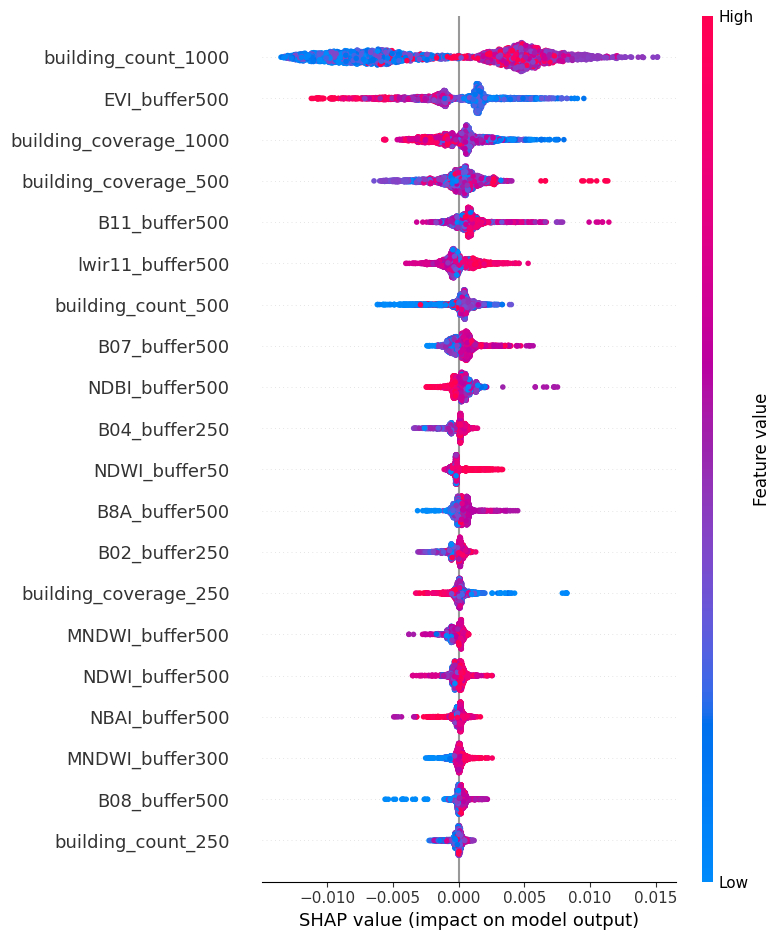

In [13]:
# Initialize SHAP explainer
explainer = shap.Explainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(
    shap_values,
    features = X_test,
    feature_names=X.columns
)

<h5 style="color:rgb(0, 210, 255)">

- It's visible that all of the important features to the model are the features with focal buffer applied.
- Building count and building coverage generated from the KML data are also important features to the model.

</h5>

In [14]:
# Get the mean absolute SHAP values for each feature
vals = np.abs(shap_values).mean(0)
# Create a DataFrame to show feature importance values
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['feature','feature_importance_value'])

# Sort the DataFrame by feature importance values
feature_importance.sort_values(
    by=['feature_importance_value'],
    ascending=False,
    inplace=True
    )
feature_importance

,feature,feature_importance_value
5,building_count_1000,6.243242e-03
136,EVI_buffer500,2.548924e-03
4,building_coverage_1000,1.425261e-03
2,building_coverage_500,1.241287e-03
75,B11_buffer500,9.382265e-04
...,...,...
123,SAVI_buffer250,3.982170e-08
102,SAVI_buffer50,0.000000e+00
116,SAVI_buffer200,0.000000e+00
137,SAVI_buffer500,0.000000e+00


Retrain the model with the top n features

In [15]:
# Let's take top 50 features
n=50
topn = feature_importance[:n]['feature'].tolist()

# Retrain the model
X_train, X_test, y_train, y_test = utils.train_test_spliter(
    train_data[topn + ['UHI Index']], 
    'UHI Index'
)

model_object = Modelling(X_train, X_test, y_train, y_test)

# Train & tune the model with the top features
tuned_xgb_topn = model_object.train(
    model = model,
    param_tune=True,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='r2'
)

# Predict with the tuned model
model_object.predict(tuned_xgb_topn)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Training took 11.63 seconds
Fitted model with hyperparameter tuning
Best Parameters: {'subsample': 1, 'n_estimators': 300, 'min_child_weight': 0, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
Best Cross-Validation Score: 0.9404508877722346
Predicting using the original train and test sets...
R² Score on train set: 0.9990
MAE: 0.0004
RMSE: 0.0000
R² Score on test set: 0.9613
MAE: 0.0023
RMSE: 0.0000


In [28]:
# Let's save the model
model_object.save_model(tuned_xgb_topn, 'models/tuned_xgb_topn.pkl')

Model saved to models/tuned_xgb_topn.pkl


<h5 style="color:rgb(0, 210, 255)">

Model performance improves slightly after feature selection.

</h5>

<h4 style="color:rgb(8, 72, 135)">3. Predict on the competition's test set</h4>

**Load the model and skip all the training steps**

In [ ]:
# uhi_data.to_csv('data/processed/uhi_data.csv', index=False)
uhi_data= pd.read_csv('data/processed/uhi_data.csv')

# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
train_data = uhi_data.drop(columns=[
    'Longitude', 'Latitude', 'datetime',
    ])
X = train_data.drop(columns=['UHI Index'])
X_train, X_test, y_train, y_test = utils.train_test_spliter(train_data, 'UHI Index')

model_object = Modelling(X_train, X_test, y_train, y_test)
tuned_xgb_topn = model_object.load_model('models/tuned_xgb_topn.pkl')

In [25]:
# Reading the coordinates for the submission
test_file = pd.read_csv('data/test/Submission_template.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [ ]:
# Extracting the band values for the test data
manipulator = SatelliteDataManipulator(
    sentinel_tiff="data/interim/Sen2.tiff",
    landsat_tiff="data/interim/Landsat_LST.tiff",
    ground_df_path="data/interim/test_ground_df.csv",
    sentinel_bands=sentinel_bands,
    landsat_bands=landsat_bands,
    buffer_sizes=buffer_sizes
)
val_data = manipulator.extract_band_values()
val_data = manipulator.calc_band_indices(val_data)

# Load ground dataset
test_ground_df = pd.read_csv("data/interim/test_ground_df.csv")
# Simply use `pd.concat` as we've already get the data based on each lon & lat of ground_df
test_satground_df = pd.concat([test_ground_df,val_data], axis=1)
test_satground_df.head()

test_data = test_satground_df

In [ ]:
# or run this to load the test data skipping the extraction
# test_data = pd.read_csv('data/test/test_data.csv')

In [ ]:
test_set = test_data.drop(['Longitude', 'Latitude', 'UHI Index'], axis=1)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
test_set = test_set[topn]
test_set = sc.transform(test_set)

final_predictions = tuned_xgb_topn.predict(test_set)
final_prediction_series = pd.Series(final_predictions)

# Combining the results into dataframe
submission_df1 = pd.DataFrame(
    {
        'Longitude':test_file['Longitude'].values, 
        'Latitude':test_file['Latitude'].values, 
        'UHI Index':final_prediction_series.values}
)

# Dumping the predictions into a csv file.
submission_df1.to_csv("output/submission1.csv",index = False)

<h4 style="color:rgb(8, 72, 135)">

The submission file is uploaded to the competition's submission page and the accuracy score is updated on the leaderboard frequently.

At the final day of the competition, our team:

- Ranked 67th global among 10,000+ participants (each team max 3 members), 
- Ranked 7th in Australia
- Model accuracy score of 0.968 on competition's test set.

</h4>